In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import random
import os
from scipy.interpolate import interp1d
import tqdm

In [2]:
# ZERO-POINT ENERGY CALCULATION
Nc = 17

df2 = pd.read_csv(
    r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\IRdata\scaled_frequencies\CNpy_scaled_output.txt',
    skiprows=1,
    sep='\s+',
    names=["Wavenumber", "Intensity"])

wavenumber_list = df2["Wavenumber"].tolist()
h_ev = 4.135667696e-15  # eV*s
c_cm = 2.99792458e10    # cm/s

zero_point_energy = 0.5 * sum([h_ev * c_cm * wn for wn in wavenumber_list])  # in eV
print("Zero-point energy (eV):", zero_point_energy)

def ionization_potential(Z, Nc):
    IP = 4.4 + (Z + 0.5) * 25.1/np.sqrt(Nc)
    return IP

# CALCULATIONS
print("Ionization potential (Z=1):", ionization_potential(1, Nc), "eV")

# CONSTANTS
Nc = 17
C_estimate_IP = 13.5
fy = 10 # Yield factor for PAHs
G0_Orion_IF = 4.7 * 10 ** 4 # IF = Ionization front, derived for the Orion bar (2.2-7.1)
ne_ORION_IF = 5 * 10 ** 3
Orion_IF_photoion_rate = []

def photo_el_ionization_rate(Nc, G0, fy, lab_IP):
    J_pe = 2.5 * 10**(-13) * (13.6-lab_IP)**2 * Nc * G0 * fy
    return J_pe

C_Orion_IF_photoion_rate = photo_el_ionization_rate(Nc, G0_Orion_IF, fy, C_estimate_IP)
C_Orion_IF_photoion_point = C_Orion_IF_photoion_rate * ne_ORION_IF

Zero-point energy (eV): 5.450178350231323
Ionization potential (Z=1): 13.531466282617938 eV


In [3]:
# WAVENUMBER DATA
C1cyanopyrene_wavenumbers_list = pd.read_csv(r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\filtered_frequencies\strong_frequencies_cation2cyanopyrene.csv', header=None).squeeze().tolist()
TS_C1cyanopyrene_wavenumbers_list = pd.read_csv(r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\filtered_frequencies\transition_strong_frequencies_cation2cyanopyrene.csv', header=None).squeeze().tolist()

# PRINCIPAL MOMENTS OF INERTIA DATA & CONVERSION FACTORS
inertia_factor_au = 1.992851882e-46 # Principal moments of inertia from atomic units to kg*m^2

C1pyrene_cation_principal_moments = [2132.38041 * inertia_factor_au, 881.2545270 * inertia_factor_au, 13.63493 * inertia_factor_au]
TS_C1cyanopyrene_principal_moments = [2141.87547 * inertia_factor_au, 160.41246 * inertia_factor_au, 67.25346 * inertia_factor_au]

# CONSTANTS & PARAMETERS
c_cm = 2.99792458e10  # Speed of light in cm/s, since cm_freq is given in cm^-1
h = 6.62607015e-34 # Planck's constant in J/Hz
k_B = 1.380649e-23 # Boltzmann's constant in J/K
symmetry_number = 1 # 1-cyanonaphthalene is structurally asymmetric (also seen in principal moment inertias), so the symmetry number is 1. Also given in sigma notation
T_eval = 1000 # Temperature in K, evaluation of the partition function at 1000 K is done to see how many vibrational states are accessible at this temperature.

# FUNCTIONS
def scale_frequencies(wavenumber_list, scale_factor=0.96):
    return [freq * scale_factor for freq in wavenumber_list]

def vibrational_partition_function(wavenumbers_list, T):
    cm_freqs = np.array(wavenumbers_list)
    hz_freqs = cm_freqs * c_cm
    char_vib_temps = h * hz_freqs / k_B
    q_vibs = 1 / (1 - np.exp(-char_vib_temps / T))
    return np.prod(q_vibs)

def rotational_partition_function(symmetry_number, principal_moments, T):
    return (np.pi**2 / symmetry_number) * \
           np.sqrt(8*np.pi*principal_moments[0] * k_B*T / h**2) * \
           np.sqrt(8*np.pi*principal_moments[1] * k_B*T / h**2) * \
           np.sqrt(8*np.pi*principal_moments[2] * k_B*T / h**2)

def compute_partition_functions(wavenumbers_list, principal_moments, T, symmetry_number=1):
    q_vib = vibrational_partition_function(wavenumbers_list, T)
    q_rot = rotational_partition_function(symmetry_number, principal_moments, T)
    return q_vib, q_rot

# CALCULATIONS
q_vib_C, q_rot_C = compute_partition_functions(C1cyanopyrene_wavenumbers_list, C1pyrene_cation_principal_moments, T_eval)
q_vib_TS_C, q_rot_TS_C = compute_partition_functions(TS_C1cyanopyrene_wavenumbers_list, TS_C1cyanopyrene_principal_moments, T_eval)

print("Vibrational partition function (cation 1-cyanonaphthalene):", q_vib_C, "The rotational partition function (cation 1-cyanonaphthalene):", q_rot_C)
print("Vibrational partition function (transition state cation 1-cyanonaphthalene):", q_vib_TS_C, "The rotational partition function (transition state cation 1-cyanonaphthalene):", q_rot_TS_C)

Vibrational partition function (cation 1-cyanonaphthalene): 402.55995385521624 The rotational partition function (cation 1-cyanonaphthalene): 98750290.33341911
Vibrational partition function (transition state cation 1-cyanonaphthalene): 42013972322.0053 The rotational partition function (transition state cation 1-cyanonaphthalene): 93778304.51997262


The entropy change is: 109.45123164220526 cal/mol K


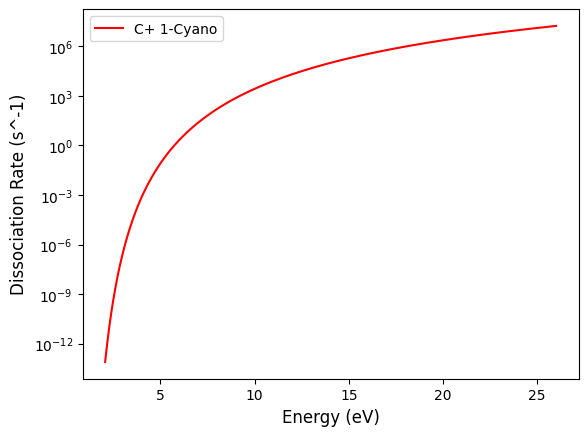

In [4]:
# CONSTANTS & PARAMETERS
Nc = 17
h_eV = 4.135667696e-15 # Planck's constant in eV/Hz
k_B = 1.380649e-23 # Boltzmann's constant in J/K
R_gas = 8.31446261815324 # Ideal gas constant in J/(mol*K)
Na = 6.02214076e23 # Avogadro's number in mol^-1
T_eval = 1000 # Temperature in K, evaluation of the partition function at 1000 K is done to see how many vibrational states are accessible at this temperature.
max_photon_frequency = 6286772e9
min_photon_frequency = 5.0e14 
C_bond_energy = 3.16 # The dissocation/activation energy of the HCN bond of cation 1-cyanonaphthalene in eV, given in the paper by H. Stockett et al. (2023) DOI: 10.1038/s41557-023-01283-0.

# LISTS
k_diss_C_list = [] 
NC_energies_list = [] 
frequency_list = np.logspace(np.log10(min_photon_frequency),np.log10(max_photon_frequency),num=10000) # Arrays of frequencies in Hz,adjust num for resolution

# FUNCTIONS
def d_entropy(q_vib_parent, q_rot_parent, q_vib_transition, q_rot_transition, activation_energy, T):
    delta_S = k_B * np.log((q_vib_transition * q_rot_transition) / (q_vib_parent * q_rot_parent)) + ((activation_energy * 1.602e-19) / T) 
    return delta_S

def PAH_effective_temperature(light_freq, Nc, bond_energy):
    T_eff = 2000 * ((h_eV * light_freq) / Nc) ** 0.4 * (1 - 0.2 * bond_energy / (h_eV * light_freq)) # energies in eV
    return T_eff

def pre_exponential_factor(T_eff, delta_S):
    k0 = k_B * T_eff / h * np.exp(1 + delta_S / R_gas)
    return k0

def unimolecular_dissociation_rate(k0, T_eff, bond_energy):
    k_diss = k0 * np.exp(-bond_energy * 1.602e-19 / (k_B * T_eff)) # energies in eV
    return k_diss

# CALCULATIONS
delta_S_C = d_entropy(q_vib_C, q_rot_C, q_vib_TS_C, q_rot_TS_C, C_bond_energy, T_eval)
print("The entropy change is:", (delta_S_C * Na / 4.184), "cal/mol K") # Convert to cal/mol K

for i in frequency_list:

    C_T_eff = PAH_effective_temperature(i, Nc, C_bond_energy) 
    NC_energies_list.append(h_eV * i)  

    k0_C = pre_exponential_factor(C_T_eff, delta_S_C)
    k_diss_C = unimolecular_dissociation_rate(k0_C, C_T_eff, C_bond_energy)
    k_diss_C_list.append(k_diss_C) 

# OPTIONAL PLOTTING
plt.plot(NC_energies_list, k_diss_C_list, label='C+ 1-Cyano', color='red')
plt.legend()
plt.xlabel('Energy (eV)', fontsize=12)
plt.ylabel('Dissociation Rate (s^-1)', fontsize=12)
plt.yscale('log')
plt.savefig(r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\plots\Teff_rates_2cpy.png')

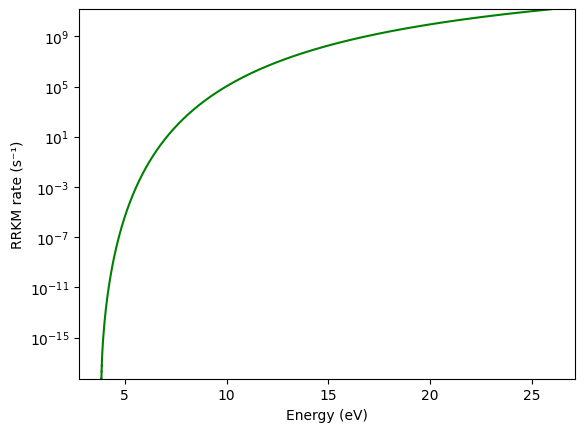

In [5]:
# TRANISTION STATE 2-CYANOPYRENE RRKM CALCULATION

# DENSUM OUTPUT DATA
df1 = pd.read_csv(
    r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\Densum_input_1cyano\Models\2-cyanopyrene\vibs\densum.out',
    skiprows=139,
    sep='\s+',
    names=["No.", "E-Emin", "Density", "Sum"])

df2 = pd.read_csv(
    r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\Densum_input_1cyano\Models\TS-2-cyanopyrene\vibs\densum.out',
    skiprows=138,
    sep='\s+',
    names=["No.", "E-Emin", "Density", "Sum"])

# CONSTANTS & PARAMETERS
h_wavenumber = 4.135667696e-15 * 8065.56 # Planck's constant in eV/cm^-1
E0_cm = 31052                            # Activation energy in cm^-1 (rounded to cm_grain)
cm_to_eV = 1.239841984e-4                
cm_grain = 10

# LISTS
density_of_states_list = df1["Density"].tolist()
TS_sum_of_states_list = df2["Sum"].tolist()
energies_list = df1["E-Emin"].tolist()
N_k_RRKM_list = []
filtered_energies_list = []

# FUNCTIONS
def RRKM_dissociation_rate(reaction_degen, TS_sum_of_states, density_of_states):
    return (reaction_degen * TS_sum_of_states) / (h_wavenumber * density_of_states)

# CALCULATIONS
for energy, density in zip(energies_list, density_of_states_list):
    if energy <= E0_cm:
        # print("Energy below threshold:", energy)
        continue

    E_available = energy - E0_cm
    # print("E_available:", E_available)
    index = int(E_available / cm_grain)
    # print("Index:", index)

    TS_sum_val = TS_sum_of_states_list[index]
    #print("sum of states:", TS_sum_val, "and density of states:", density)
    k = RRKM_dissociation_rate(reaction_degen=1, TS_sum_of_states=TS_sum_val, density_of_states=density)
    N_k_RRKM_list.append(k)
    filtered_energies_list.append(energy)

# Converts energies from cm^-1 to eV
N_RRKM_filtered_energies_list_eV = [e * cm_to_eV for e in filtered_energies_list]

# OPTIONAL PLOTTING
plt.plot(N_RRKM_filtered_energies_list_eV, N_k_RRKM_list, color='green')
plt.xlabel('Energy (eV)')
plt.ylabel('RRKM rate (s⁻¹)')
plt.yscale('log')
plt.ylim(min(N_k_RRKM_list), max(N_k_RRKM_list))
plt.savefig(r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\plots\Ncyp_RRKM.png')

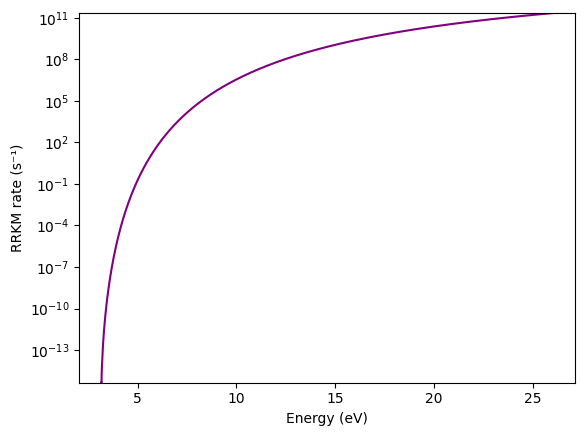

In [6]:
# ORIGINAL TRANISTION STATE 2-CYANOPYRENE+ RRKM CALCULATION

# DENSUM OUTPUT DATA
df1 = pd.read_csv(
    r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\Densum_input_1cyano\Models\C-2-cyanopyrene\vibs\densum.out',
    skiprows=139,
    sep='\s+',
    names=["No.", "E-Emin", "Density", "Sum"])

df2 = pd.read_csv(
    r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\Densum_input_1cyano\Models\TS-C-2-cyanopyrene\vibs\densum.out',
    skiprows=138,
    sep='\s+',
    names=["No.", "E-Emin", "Density", "Sum"])

# CONSTANTS & PARAMETERS
h_wavenumber = 4.135667696e-15 * 8065.56
E0_cm = 25490                           
cm_to_eV = 1.239841984e-4                
cm_grain = 10

# LISTS
density_of_states_list = df1["Density"].tolist()
TS_sum_of_states_list = df2["Sum"].tolist()
energies_list = df1["E-Emin"].tolist()
C_k_RRKM_list = []
filtered_energies_list = []

# FUNCTIONS
def RRKM_dissociation_rate(reaction_degen, TS_sum_of_states, density_of_states):
    return (reaction_degen * TS_sum_of_states) / (h_wavenumber * density_of_states)

# CALCULATIONS
for energy, density in zip(energies_list, density_of_states_list):
    if energy <= E0_cm:
        continue

    E_available = energy - E0_cm
    index = int(E_available / cm_grain)

    TS_sum_val = TS_sum_of_states_list[index]
    k = RRKM_dissociation_rate(reaction_degen=1, TS_sum_of_states=TS_sum_val, density_of_states=density)
    C_k_RRKM_list.append(k)
    filtered_energies_list.append(energy)

C_RRKM_filtered_energies_list_eV = [e * cm_to_eV for e in filtered_energies_list]

# OPTIONAL PLOTTING
plt.plot(C_RRKM_filtered_energies_list_eV, C_k_RRKM_list, color='purple')
plt.xlabel('Energy (eV)')
plt.ylabel('RRKM rate (s⁻¹)')
plt.yscale('log')
plt.ylim(min(C_k_RRKM_list), max(C_k_RRKM_list))
plt.savefig(r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\plots\Ccyp_RRKM.png')

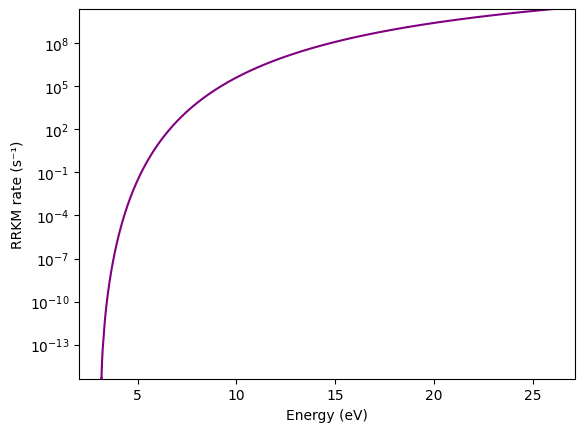

In [7]:
# OTHER TRANISTION STATE 2-CYANOPYRENE+ RRKM CALCULATION

# DENSUM OUTPUT DATA
df1 = pd.read_csv(
    r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\Densum_input_1cyano\Models\C-2-cyanopyrene\vibs\densum.out',
    skiprows=139,
    sep='\s+',
    names=["No.", "E-Emin", "Density", "Sum"])

df2 = pd.read_csv(
    r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\Densum_input_1cyano\Models\other-TS-C-2-cyanopyrene\vibs\densum.out',
    skiprows=138,
    sep='\s+',
    names=["No.", "E-Emin", "Density", "Sum"])

# CONSTANTS & PARAMETERS
h_wavenumber = 4.135667696e-15 * 8065.56
E0_cm = 25490                           
cm_to_eV = 1.239841984e-4                
cm_grain = 10

# LISTS
density_of_states_list = df1["Density"].tolist()
TS_sum_of_states_list = df2["Sum"].tolist()
energies_list = df1["E-Emin"].tolist()
other_C_k_RRKM_list = []
filtered_energies_list = []

# FUNCTIONS
def RRKM_dissociation_rate(reaction_degen, TS_sum_of_states, density_of_states):
    return (reaction_degen * TS_sum_of_states) / (h_wavenumber * density_of_states)

# CALCULATIONS
for energy, density in zip(energies_list, density_of_states_list):
    if energy <= E0_cm:
        continue

    E_available = energy - E0_cm
    index = int(E_available / cm_grain)

    TS_sum_val = TS_sum_of_states_list[index]
    k = RRKM_dissociation_rate(reaction_degen=1, TS_sum_of_states=TS_sum_val, density_of_states=density)
    other_C_k_RRKM_list.append(k)
    filtered_energies_list.append(energy)

other_C_RRKM_filtered_energies_list_eV = [e * cm_to_eV for e in filtered_energies_list]

# OPTIONAL PLOTTING
plt.plot(other_C_RRKM_filtered_energies_list_eV, other_C_k_RRKM_list, color='purple')
plt.xlabel('Energy (eV)')
plt.ylabel('RRKM rate (s⁻¹)')
plt.yscale('log')
plt.ylim(min(other_C_k_RRKM_list), max(other_C_k_RRKM_list))
plt.savefig(r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\plots\other_Ccyp_RRKM.png')

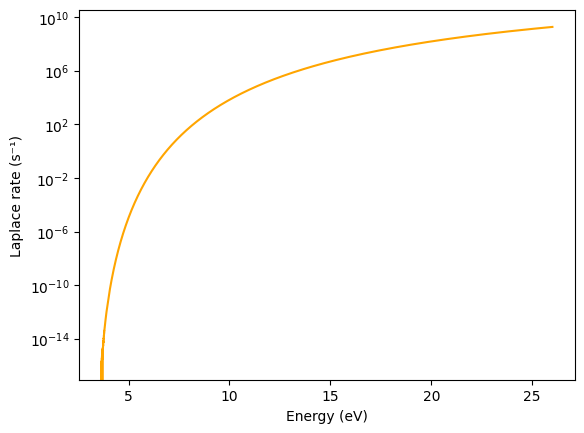

In [8]:
# 2-CYANOPYRENE INVERSE LAPLACE DISSOCIATON RATE

# DOS DATA
df = pd.read_csv(
    r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\Densum_input_1cyano\Models\2-cyanopyrene\vibs\densum.out',
    skiprows=139,
    sep='\s+',
    names=["No.", "E-Emin", "Density", "Sum"])

# CONSTANTS & PARAMETERS
T_eff = 1000
h = 6.62607015e-34 
k_B = 1.380649e-23 
E0_cm = 29520                        
cm_to_eV = 1.239841984e-4
cm_grain = 10

# LISTS
Ncyp_k_Laplace_list = []
filtered_energies_list = []
energies_list = df["E-Emin"]
density_of_states_list1 = df["Density"].tolist()
density_of_states_list2 = df["Density"].tolist()

# FUNCTIONS
def pre_exponential_factor_1000K(T_eff):
    A_diss_1000K = k_B * T_eff / h
    return A_diss_1000K

def Laplace_dissociation_rate(A_diss_1000K, DOS_E_Ea, DOS_E):
    k_diss_laplace = (A_diss_1000K * DOS_E_Ea) / DOS_E
    return k_diss_laplace
    
# CALCULATIONS
for energy, unchanged_DOS in zip(energies_list, density_of_states_list2):
    if energy <= E0_cm:
        continue

    E_available = energy - E0_cm
    index = int(E_available / cm_grain)

    changed_DOS = density_of_states_list1[index]
    k = Laplace_dissociation_rate(A_diss_1000K=(pre_exponential_factor_1000K(T_eff)), DOS_E_Ea=changed_DOS, DOS_E=unchanged_DOS)
    Ncyp_k_Laplace_list.append(k)
    filtered_energies_list.append(energy)

Ncyp_LP_filtered_energies_list_eV = [e * cm_to_eV for e in filtered_energies_list]

# OPTIONAL PLOTTING
plt.plot(Ncyp_LP_filtered_energies_list_eV, Ncyp_k_Laplace_list, color='orange')
plt.xlabel('Energy (eV)')
plt.ylabel('Laplace rate (s⁻¹)')
plt.yscale('log')
plt.savefig(r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\plots\Ncyp_LP.png')

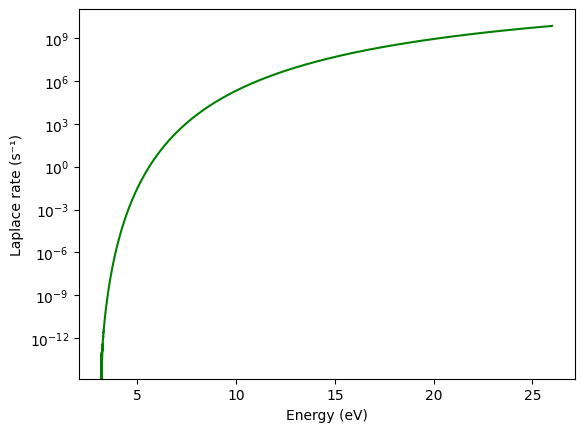

In [9]:
# 2-CYANOPYRENE+ INVERSE LAPLACE DISSOCIATON RATE

# DOS DATA
df = pd.read_csv(
    r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\Densum_input_1cyano\Models\C-2-cyanopyrene\vibs\densum.out',
    skiprows=139,
    sep='\s+',
    names=["No.", "E-Emin", "Density", "Sum"])

# CONSTANTS & PARAMETERS
T_eff = 1000
h = 6.62607015e-34 
k_B = 1.380649e-23 
E0_cm = 25490                           
cm_to_eV = 1.239841984e-4
cm_grain = 10

# LISTS
Ccyp_k_Laplace_list = []
filtered_energies_list = []
energies_list = df["E-Emin"]
density_of_states_list1 = df["Density"].tolist()
density_of_states_list2 = df["Density"].tolist()

# FUNCTIONS
def pre_exponential_factor_1000K(T_eff):
    A_diss_1000K = k_B * T_eff / h
    return A_diss_1000K

def Laplace_dissociation_rate(A_diss_1000K, DOS_E_Ea, DOS_E):
    k_diss_laplace = (A_diss_1000K * DOS_E_Ea) / DOS_E
    return k_diss_laplace
    
# CALCULATIONS
for energy, unchanged_DOS in zip(energies_list, density_of_states_list2):
    if energy <= E0_cm:
        continue

    E_available = energy - E0_cm
    index = int(E_available / cm_grain)

    changed_DOS = density_of_states_list1[index]
    k = Laplace_dissociation_rate(A_diss_1000K=(pre_exponential_factor_1000K(T_eff)), DOS_E_Ea=changed_DOS, DOS_E=unchanged_DOS)
    Ccyp_k_Laplace_list.append(k)
    filtered_energies_list.append(energy)

Ccyp_LP_filtered_energies_list_eV = [e * cm_to_eV for e in filtered_energies_list]

# OPTIONAL PLOTTING
plt.plot(Ccyp_LP_filtered_energies_list_eV, Ccyp_k_Laplace_list, color='green')
plt.xlabel('Energy (eV)')
plt.ylabel('Laplace rate (s⁻¹)')
plt.yscale('log')
plt.savefig(r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\plots\Ccyp_LP.png')

C:\Users\Mustafa\AppData\Local\Temp\ipykernel_15272\4285997946.py:60: RuntimeWarning: invalid value encountered in scalar divide
  k_IR = (A_IR * DOS_mode_s) / density_of_states_list[idx]


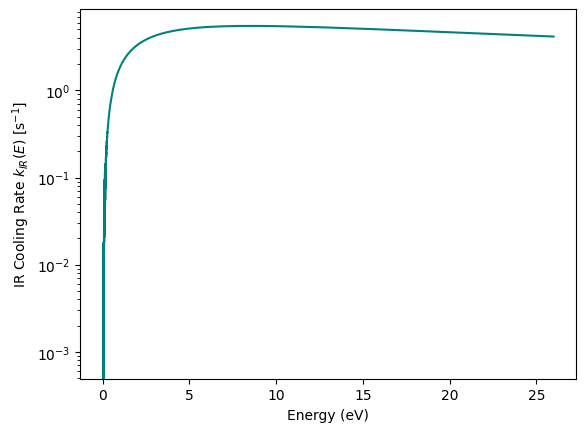

<Figure size 640x480 with 0 Axes>

In [10]:
# 2-CYANOPYRENE INFRARED RADIATIVE VIBRATIONAL COOLING RATE 

# WAVENUMBER-INTENSITY & DENSUM DATA
df1 = pd.read_csv(
    r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\Densum_input_1cyano\Models\2-cyanopyrene\vibs\densum.out',
    skiprows=139,
    sep='\s+',
    names=["No.", "E-Emin", "Density", "Sum"])

df2 = pd.read_csv(
    r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\IRdata\scaled_frequencies\CNpy_scaled_output.txt',
    skiprows=1,
    sep='\s+',
    names=["Wavenumber", "Intensity"])

mode_i_path = r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\Densum_input_1cyano\Models\2-cyanopyrene\vibs\densum_mode_sweeps\mode_{i}\densum.out'
density_mode = {}

for i in range(1, 76):  # Vib modes 1 to 75
    path = mode_i_path.format(i=i)
    if os.path.exists(path):
        df_i = pd.read_csv(path, skiprows=138, sep='\s+', names=["No.", "E-Emin", "Density", "Sum"])
        density_mode[i] = df_i["Density"].values

# LISTS
A_IR_list = []
energy_s_list = []
DOS_list = []
filtered_energies_list = []
wavenumber_list = df2["Wavenumber"].tolist()
intensity_list = df2["Intensity"].tolist()
energies_list = df1["E-Emin"].tolist()
density_of_states_list = df1["Density"].tolist()
N_k_IR_total = np.zeros_like(density_of_states_list) 
DOS_mode_s_dict = {}  # Dictionary to store DOS_mode_s values for each mode

# FUNCTIONS
def einstein_coefficient(wavenumber, intensity):
    A = (1.2512 * 10**(-7)) * (wavenumber ** 2) * intensity
    return A

# CALCULATIONS
for wavenumber, intensity in zip(wavenumber_list, intensity_list):
    A_IR = einstein_coefficient(wavenumber, intensity)
    A_IR_list.append(A_IR)

for mode in range(1, 52):
    wavenumber_s = wavenumber_list[mode - 1]
    rounded_wavenumber = round(wavenumber_s / 10) * 10
    A_IR = A_IR_list[mode - 1]
    # rho_minus_i = density_mode[mode]

    for idx, e in enumerate(energies_list):
        if e <= rounded_wavenumber:
            continue
        E_available = e - rounded_wavenumber
        index = int(E_available / cm_grain)

        DOS_mode_s = density_mode[mode][index]
        k_IR = (A_IR * DOS_mode_s) / density_of_states_list[idx]
        N_k_IR_total[idx] += k_IR

N_IR_energies_list_eV = [e * cm_to_eV for e in energies_list]

# OPTIONAL PLOTTING
plt.plot(N_IR_energies_list_eV, N_k_IR_total, color='teal')
plt.xlabel("Energy (eV)")
plt.ylabel("IR Cooling Rate $k_{IR}(E)$ [s$^{-1}$]")
plt.yscale('log')
plt.show()
plt.savefig(r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\plots\Ncyp_IR.png')

C:\Users\Mustafa\AppData\Local\Temp\ipykernel_15272\2738113618.py:60: RuntimeWarning: invalid value encountered in scalar divide
  k_IR = (A_IR * DOS_mode_s) / density_of_states_list[idx]


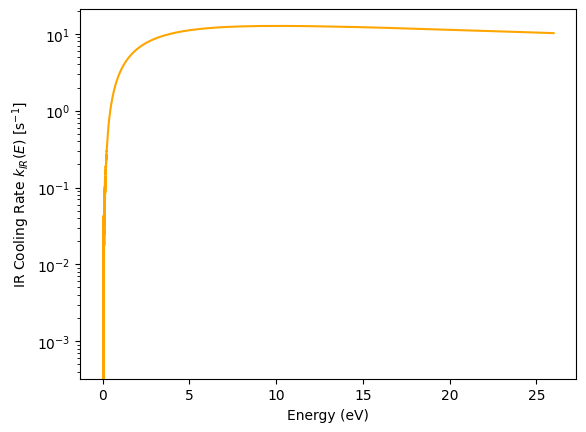

<Figure size 640x480 with 0 Axes>

In [11]:
# 2-CYANOPYRENE+ INFRARED RADIATIVE VIBRATIONAL COOLING RATE 

# WAVENUMBER-INTENSITY & DENSUM DATA
df1 = pd.read_csv(
    r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\Densum_input_1cyano\Models\C-2-cyanopyrene\vibs\densum.out',
    skiprows=139,
    sep='\s+',
    names=["No.", "E-Emin", "Density", "Sum"])

df2 = pd.read_csv(
    r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\IRdata\scaled_frequencies\CNpy+_scaled_output.txt',
    skiprows=1,
    sep='\s+',
    names=["Wavenumber", "Intensity"])

mode_i_path = r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\Densum_input_1cyano\Models\C-2-cyanopyrene\vibs\densum_mode_sweeps\mode_{i}\densum.out'
density_mode = {}

for i in range(1, 76):  # Vib modes 1 to 75
    path = mode_i_path.format(i=i)
    if os.path.exists(path):
        df_i = pd.read_csv(path, skiprows=138, sep='\s+', names=["No.", "E-Emin", "Density", "Sum"])
        density_mode[i] = df_i["Density"].values

# LISTS
A_IR_list = []
energy_s_list = []
DOS_list = []
filtered_energies_list = []
wavenumber_list = df2["Wavenumber"].tolist()
intensity_list = df2["Intensity"].tolist()
energies_list = df1["E-Emin"].tolist()
density_of_states_list = df1["Density"].tolist()
C_k_IR_total = np.zeros_like(density_of_states_list) 
DOS_mode_s_dict = {}  # Dictionary to store DOS_mode_s values for each mode

# FUNCTIONS
def einstein_coefficient(wavenumber, intensity):
    A = (1.2512 * 10**(-7)) * (wavenumber ** 2) * intensity
    return A

# CALCULATIONS
for wavenumber, intensity in zip(wavenumber_list, intensity_list):
    A_IR = einstein_coefficient(wavenumber, intensity)
    A_IR_list.append(A_IR)

for mode in range(1, 52):
    wavenumber_s = wavenumber_list[mode - 1]
    rounded_wavenumber = round(wavenumber_s / 10) * 10
    A_IR = A_IR_list[mode - 1]
    # rho_minus_i = density_mode[mode]

    for idx, e in enumerate(energies_list):
        if e <= rounded_wavenumber:
            continue
        E_available = e - rounded_wavenumber
        index = int(E_available / cm_grain)

        DOS_mode_s = density_mode[mode][index]
        k_IR = (A_IR * DOS_mode_s) / density_of_states_list[idx]
        C_k_IR_total[idx] += k_IR

C_IR_energies_list_eV = [e * cm_to_eV for e in energies_list]

# OPTIONAL PLOTTING
plt.plot(C_IR_energies_list_eV, C_k_IR_total, color='orange')
plt.xlabel("Energy (eV)")
plt.ylabel("IR Cooling Rate $k_{IR}(E)$ [s$^{-1}$]")
plt.yscale('log')
plt.show()
plt.savefig(r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\plots\Ccyp_IR.png')

Pre-exponential factor for RF: 46538.84718602217 s^-1


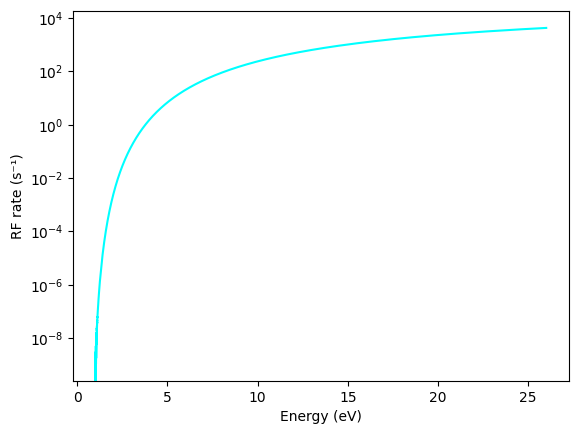

<Figure size 640x480 with 0 Axes>

In [12]:
# 2-CYANOPYRENE+ RECURRENT FLUORESCENCE RATE

# DOS DATA
df = pd.read_csv(
    r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\Densum_input_1cyano\Models\C-2-cyanopyrene\vibs\densum.out',
    skiprows=139,
    sep='\s+',
    names=["No.", "E-Emin", "Density", "Sum"])

# CONSTANTS & PARAMETERS
# Recurrent Fluorescence rate parameters: v_el=1.518 eV with f=0.0008 and v_el=1.963 eV with f=0.0352. 
h_eV = 4.135667696e-15 # Planck's constant in eV/Hz
eps_0 = 8.854e-12   # Vacuum permitivity in C^2 /(N*m^2) or also C^2 /(kg*m^3*s^2)
m_e = 9.109e-31     # Electron mass in kg
e = 1.602e-19       # Elementary charge in C
c = 2.998e8         # Speed of light in m/s
f_osc = 0.0008       # Oscillator strength for RF. 
v_el = 1.158 / h_eV  # Electronic energy for 2-cyanopyrene in eV, converted to Hz using h_eV
wave_v_el = 8070    # cm^-1 for cation 2-cyanopyrene

# LISTS
k_RF_list = []
filtered_energies_list = []
energies_list = df["E-Emin"].tolist()
density_of_states_list1 = df["Density"].tolist()
density_of_states_list2 = df["Density"].tolist()

# FUNCTIONS
def pre_exponential_factor_RF(v_el, f_osc):
    A_RF = (2 * np.pi * (v_el ** 2) * (e **2) * f_osc) / (eps_0 * m_e * c ** 3)
    return A_RF

print("Pre-exponential factor for RF:", pre_exponential_factor_RF(v_el, f_osc), "s^-1")

def RF_dissociation_rate(A_RF, DOS_E_vel, DOS_E):
    k_RF = (A_RF * DOS_E_vel) / DOS_E
    return k_RF

# CALCULATIONS
for energy, unchanged_DOS in zip(energies_list, density_of_states_list2):
    if energy <= wave_v_el:
        continue

    E_available = energy - wave_v_el
    index = int(E_available / cm_grain)

    changed_DOS = density_of_states_list1[index]
    k = RF_dissociation_rate(A_RF=(pre_exponential_factor_RF(v_el, f_osc)), DOS_E_vel=changed_DOS, DOS_E=unchanged_DOS)
    k_RF_list.append(k)
    filtered_energies_list.append(energy)

RF_filtered_energies_list_eV = [e * cm_to_eV for e in filtered_energies_list]

# OPTIONAL PLOTTING
plt.plot(RF_filtered_energies_list_eV, k_RF_list, color='cyan')
plt.xlabel('Energy (eV)')
plt.ylabel('RF rate (s⁻¹)')
plt.yscale('log')
plt.show()
plt.savefig(r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\plots\Ccyp_RF.png')


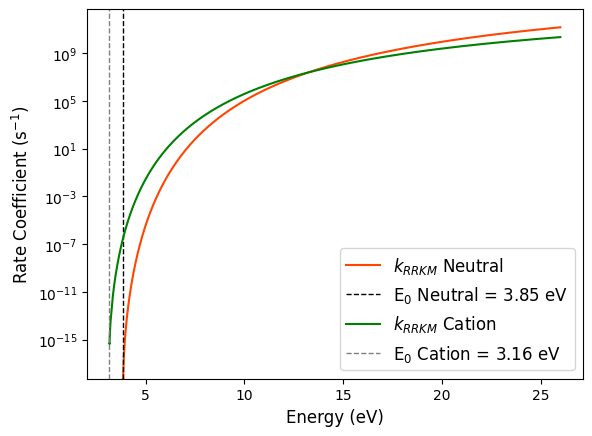

In [13]:
# NEUTRAL 2-CYANOPYRENE DISSOCIATION RATES
plt.plot(N_RRKM_filtered_energies_list_eV, N_k_RRKM_list, label='$k_{RRKM}$ Neutral', color='orangered')
plt.axvline(x=3.85, color='black', linestyle='--', linewidth=1, label='E$_0$ Neutral = 3.85 eV')

# CATION 2-CYANOPYRENE+ DISSOCIATION RATES
plt.plot(other_C_RRKM_filtered_energies_list_eV, other_C_k_RRKM_list, label='$k_{RRKM}$ Cation', color='green')
plt.axvline(x=3.16, color='grey', linestyle='--', linewidth=1, label='E$_0$ Cation = 3.16 eV')

plt.ylabel(r'Rate Coefficient (s$^{-1}$)', fontsize=12)
plt.xlabel('Energy (eV)', fontsize=12)
plt.yscale('log')
plt.legend(fontsize=12)
plt.ylim(min(N_k_RRKM_list[0], other_C_k_RRKM_list[0]), 5e12)
plt.show()

(2.067833848, 13.6)

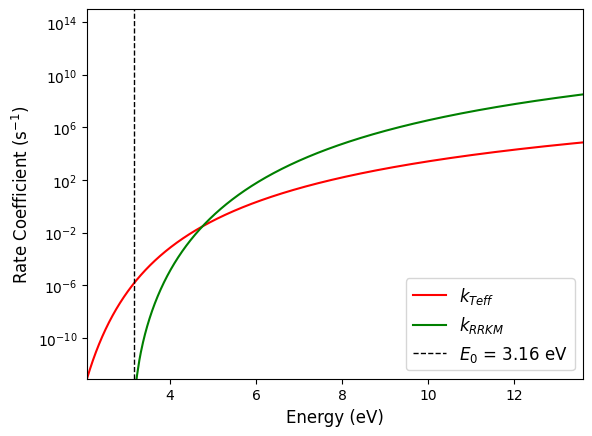

In [14]:
plt.plot(NC_energies_list, k_diss_C_list, label='$k_{Teff}$', color='red', linestyle='-')
plt.plot(C_RRKM_filtered_energies_list_eV, C_k_RRKM_list, label='$k_{RRKM}$', color='green')
plt.axvline(x=3.16, color='black', linestyle='--', linewidth=1, label=r'$E_0$ = 3.16 eV')
plt.ylabel(r'Rate Coefficient (s$^{-1}$)', fontsize=12)
plt.xlabel('Energy (eV)', fontsize=12)
plt.yscale('log')
plt.legend(fontsize=12)
plt.ylim(k_diss_C_list[0], 1e15)
plt.xlim(NC_energies_list[0], 13.6)

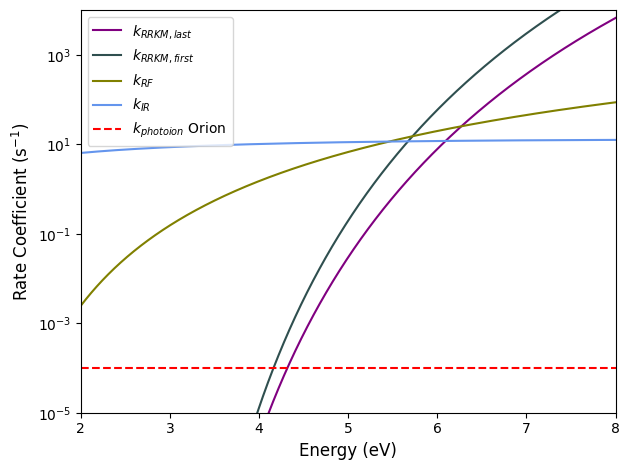

In [15]:
# 2-CYANOPYRENE+ ALL RATE COEFFICIENTS COMBINED PLOT
#plt.plot(Ccyp_LP_filtered_energies_list_eV, Ccyp_k_Laplace_list, color='darkslategrey', label='$k_{Laplace}$')
plt.plot(other_C_RRKM_filtered_energies_list_eV, other_C_k_RRKM_list, color='purple', label='$k_{RRKM, last}$')
plt.plot(C_RRKM_filtered_energies_list_eV, C_k_RRKM_list, color='darkslategrey', label='$k_{RRKM, first}$')
plt.plot(RF_filtered_energies_list_eV, k_RF_list, color='olive', label='$k_{RF}$')
plt.plot(C_IR_energies_list_eV, C_k_IR_total, color='cornflowerblue', label='$k_{IR}$')
plt.axhline(y=C_Orion_IF_photoion_point, color='red', linestyle='--', label='$k_{photoion}$ Orion ')
plt.xlabel('Energy (eV)', fontsize=12)
plt.ylabel('Rate Coefficient (s$^{-1}$)', fontsize=12)
plt.yscale('log')
plt.legend(loc='upper left', fontsize = 10)
plt.xlim(2, 8)
plt.ylim(1e-5, 1e4)
plt.tight_layout()
plt.show()

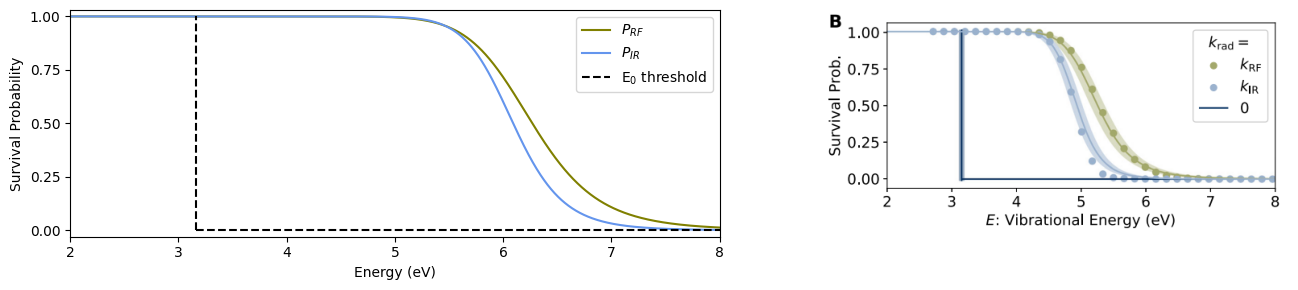

In [16]:
# 2-CYANOPYRENE+ SURVIVAL PROBABILITIES COMPARED TO STOCKETT ET AL. PAPER PLOT
C_threshold_eV = 3.16

interp_other_rrkm = interp1d(other_C_RRKM_filtered_energies_list_eV, other_C_k_RRKM_list, bounds_error=False, fill_value="extrapolate")
interp_RF = interp1d(RF_filtered_energies_list_eV, k_RF_list, bounds_error=False, fill_value="extrapolate")

C_k_other_rrkm_interp = interp_other_rrkm(C_IR_energies_list_eV)
k_RF_interp = interp_RF(C_IR_energies_list_eV)

C_survival_prob_IR = C_k_IR_total / (C_k_other_rrkm_interp + C_k_IR_total)
C_survival_prob_RF = k_RF_interp / (C_k_other_rrkm_interp + k_RF_interp)

fig, axs = plt.subplots(1, 2, figsize=(14, 3))

axs[0].plot(C_IR_energies_list_eV, C_survival_prob_RF, color='olive', label='$P_{RF}$')
axs[0].plot(C_IR_energies_list_eV, C_survival_prob_IR, color='cornflowerblue', label='$P_{IR}$')
axs[0].plot([C_threshold_eV, C_threshold_eV], [0, 1], color='black', linestyle='--', label='E$_0$ threshold')
axs[0].plot([C_threshold_eV, 8], [0, 0], color='black', linestyle='--')
axs[0].set_xlabel("Energy (eV)")
axs[0].set_ylabel("Survival Probability")
axs[0].set_yticks(np.arange(0, 1.25, 0.25))
axs[0].set_ylim(-0.03, 1.03)
axs[0].set_xlim(2, 8)
axs[0].legend(loc='upper right')

img = mpimg.imread('PaperplotB.png') 
axs[1].imshow(img)
axs[1].axis('off')

plt.tight_layout()
plt.show()

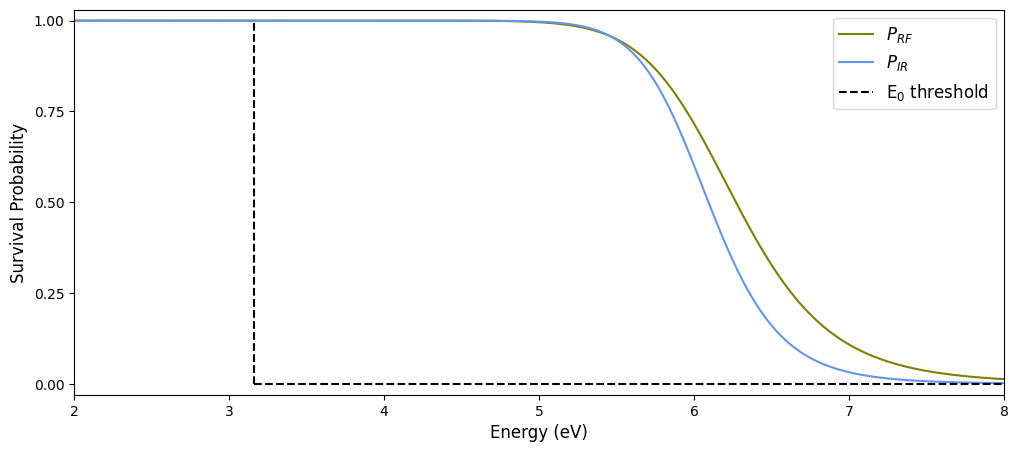

In [17]:
plt.figure(figsize=(12, 5))
plt.plot(C_IR_energies_list_eV, C_survival_prob_RF, color='olive', label='$P_{RF}$')
plt.plot(C_IR_energies_list_eV, C_survival_prob_IR, color='cornflowerblue', label='$P_{IR}$')
plt.plot([C_threshold_eV, C_threshold_eV], [0, 1], color='black', linestyle='--', label='E$_0$ threshold')
plt.plot([C_threshold_eV, 8], [0, 0], color='black', linestyle='--')
plt.xlabel("Energy (eV)", fontsize = 12)
plt.ylabel("Survival Probability", fontsize = 12)
plt.yticks(np.arange(0, 1.25, 0.25))
plt.ylim(-0.03, 1.03)
plt.xlim(2, 8)
plt.legend(loc='upper right', fontsize = 12)

Overall average energy: 5.605682947142027
All molecules destroyed after 45.17 years.
The average lifetime for a molecule is 22.58 years.


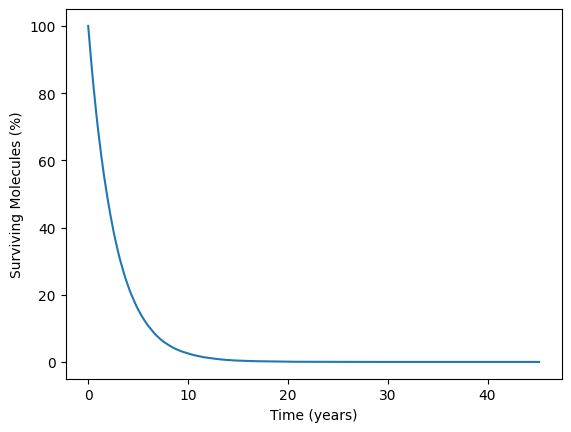

Total number of destructions: 100000
Total number of IR coolings: 1276
Total number of RF coolings: 2982


In [18]:
# MONTE CARLO SIMULATION FOR 2-CYANOPYRENE+ (VECTORIZED)

# PARAMETERS FOR MONTE CARLO SIMULATION
num_molecules = 100000
E_min = 5.45  # eV, lower limit
E_max = 13.6   # eV, upper limit
Nc = 17
G0 = 1 # FUV Habing field for the NGC 7023 region 
t_uv = 1.4e9 / (Nc * G0)
dt = 3.1536e7 / 10  # e.g. 1/10th of a year per step, adjust as needed

# LISTS AND ARRAYS
interp_RRKM = interp1d(other_C_RRKM_filtered_energies_list_eV, other_C_k_RRKM_list, bounds_error=False, fill_value=0)
interp_IR = interp1d(C_IR_energies_list_eV, C_k_IR_total, bounds_error=False, fill_value=0)
interp_RF = interp1d(RF_filtered_energies_list_eV, k_RF_list, bounds_error=False, fill_value=0)
molecule_energies = np.full(num_molecules, E_min)
molecule_alive = np.ones(num_molecules, dtype=bool)
molecule_excited = np.zeros(num_molecules, dtype=bool)
survival_history = []
time_history = []
total_average = []

# EVENT COUNTERS
rf_count = 0
ir_count = 0
destruction_count = 0

t = 0
current_time = 0.0
while np.any(molecule_alive):
    alive_mask = molecule_alive

    E = molecule_energies[alive_mask]
    idx = np.where(alive_mask)[0]
    was_excited = molecule_excited[idx]

    # RATES
    k_RRKM = interp_RRKM(E)
    k_IR = interp_IR(E) 
    k_RF = interp_RF(E) 
    
    # THRESHOLDS
    k_RRKM[E < other_C_RRKM_filtered_energies_list_eV[0]] = 0
    k_RF[E < RF_filtered_energies_list_eV[0]] = 0
    k_RRKM[~was_excited] = 0
    k_IR[~was_excited] = 0
    k_RF[~was_excited] = 0

    # PROBABILITIES
    p_RRKM = k_RRKM * dt
    p_IR = k_IR * dt
    p_RF = k_RF * dt
    p_FUV_arr = np.full_like(p_RRKM, dt / t_uv)

    # NORMALIZATION
    p_sum = p_RRKM + p_IR + p_RF + p_FUV_arr
    over_one = p_sum > 1
    p_RRKM[over_one] /= p_sum[over_one]
    p_IR[over_one]   /= p_sum[over_one]
    p_RF[over_one]   /= p_sum[over_one]
    p_FUV_arr[over_one] /= p_sum[over_one]

    rand = np.random.rand(np.sum(alive_mask))
    rrkm_mask = rand < p_RRKM
    ir_mask = (rand >= p_RRKM) & (rand < p_RRKM + p_IR)
    rf_mask = (rand >= p_RRKM + p_IR) & (rand < p_RRKM + p_IR + p_RF)
    fuv_mask = (rand >= p_RRKM + p_IR + p_RF) & (rand < p_RRKM + p_IR + p_RF + p_FUV_arr)

    # EVENT COUNTS
    destruction_count += np.sum(rrkm_mask)
    ir_count += np.sum(ir_mask)
    rf_count += np.sum(rf_mask)

    # UPDATE MOLECULE INTERNAL ENERGY
    molecule_alive[idx[rrkm_mask]] = False

    molecule_energies[idx[ir_mask]] = E_min
    molecule_excited[idx[ir_mask]] = False  # Reset excited state after IR cooling
    
    molecule_energies[idx[rf_mask]] = E_min
    molecule_excited[idx[rf_mask]] = False  # Reset excited state after RF cooling

    E_FUV_GAIN = np.random.uniform(0.5, 13.6, size=np.sum(fuv_mask))
    molecule_energies[idx[fuv_mask]] = np.minimum(E[fuv_mask] + E_FUV_GAIN, E_max)
    molecule_excited[idx[fuv_mask]] = True 

    # APPEND HISTORIES
    survival_history.append(np.sum(molecule_alive))
    time_history.append(current_time)
    avg_energy = np.mean(molecule_energies[molecule_alive]) if np.any(molecule_alive) else 0
    total_average.append(avg_energy)

    current_time += dt
    t += 1

# FINAL AVERAGE ENERGY
overall_avg_energy = np.mean(total_average)
print("Overall average energy:", overall_avg_energy)

# TIME TO ZERO MOLECULES
years_to_zero = time_history[-1] / 3.15576e7
print(f"All molecules destroyed after {years_to_zero:.2f} years.")
print(f"The average lifetime for a molecule is {np.mean(time_history) / 3.15576e7:.2f} years.")
os.makedirs(r"C:\Users\Mustafa\Documents\GitHub\Project-Cynap\plots", exist_ok=True)

# PLOTS
plt.plot(np.array(time_history) / 3.15576e7, 100 * np.array(survival_history) / num_molecules)
plt.xlabel('Time (years)')
plt.ylabel('Surviving Molecules (%)')
plt.savefig(fr"C:\Users\Mustafa\Documents\GitHub\Project-Cynap\plots\{G0}_montecarlo_cpy+.png")
plt.show()

# event_labels = ['Destruction', 'IR Cooling', 'RF']
# event_counts = [destruction_count, ir_count, rf_count]
# plt.bar(event_labels, event_counts, color=['red', 'blue', 'olive'], edgecolor='black')
# plt.ylabel('Number of Events')
# plt.show()

print("Total number of destructions:", destruction_count)
print("Total number of IR coolings:", ir_count) 
print("Total number of RF coolings:", rf_count)

Average energy over 1000 runs: 7.6289 eV
Average lifetime over 1000 runs: 0.25 years
Average years to zero molecules over 1000 runs: 0.61 years
Standard deviation of years to zero molecules over 1000 runs: 0.11 years
Variance of years to zero molecules over 1000 runs: 0.01 years
Maximum difference in years to zero molecules over 1000 runs: 0.40 years


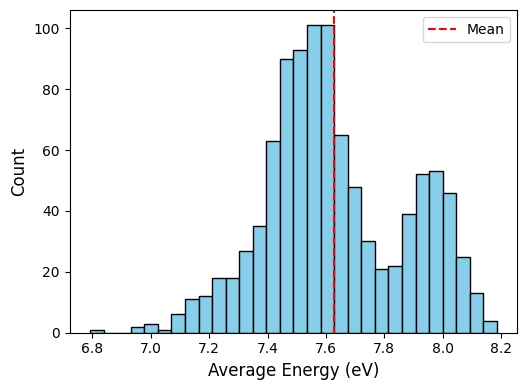

In [19]:
# MULTIPLE MONTE CARLO SIMULATION FOR 2-CYANOPYRENE+ (VECTORIZED)

n = 1000  # Number of Monte Carlo runs
num_molecules = 10000
E_min = 5.45  # eV, lower limit
E_max = 13.6   # eV, upper limit
Nc = 17
G0 = 300000 # FUV Habing field for the NGC 7023 region 
t_uv = 1.4e9 / (Nc * G0)
dt = 3.1536e7 / 10  # e.g. 1/10th of a year per step

interp_RRKM = interp1d(other_C_RRKM_filtered_energies_list_eV, other_C_k_RRKM_list, bounds_error=False, fill_value=0)
interp_IR = interp1d(C_IR_energies_list_eV, C_k_IR_total, bounds_error=False, fill_value=0)
interp_RF = interp1d(RF_filtered_energies_list_eV, k_RF_list, bounds_error=False, fill_value=0)

all_avg_energies = []
all_years_to_zero = []

for run in range(n):
    molecule_energies = np.full(num_molecules, E_min)
    molecule_alive = np.ones(num_molecules, dtype=bool)
    molecule_excited = np.zeros(num_molecules, dtype=bool)
    total_average = []
    time_history = []
    t = 0
    current_time = 0.0

    while np.any(molecule_alive):
        alive_mask = molecule_alive
        E = molecule_energies[alive_mask]
        idx = np.where(alive_mask)[0]
        was_excited = molecule_excited[idx]

        k_RRKM = interp_RRKM(E)
        k_IR = interp_IR(E) 
        k_RF = interp_RF(E) 

        k_RRKM[E < other_C_RRKM_filtered_energies_list_eV[0]] = 0
        k_RF[E < RF_filtered_energies_list_eV[0]] = 0
        k_RRKM[~was_excited] = 0
        k_IR[~was_excited] = 0
        k_RF[~was_excited] = 0

        p_RRKM = k_RRKM * dt
        p_IR = k_IR * dt
        p_RF = k_RF * dt
        p_FUV_arr = np.full_like(p_RRKM, dt / t_uv)

        p_sum = p_RRKM + p_IR + p_RF + p_FUV_arr
        over_one = p_sum > 1
        p_RRKM[over_one] /= p_sum[over_one]
        p_IR[over_one]   /= p_sum[over_one]
        p_RF[over_one]   /= p_sum[over_one]
        p_FUV_arr[over_one] /= p_sum[over_one]

        rand = np.random.rand(np.sum(alive_mask))
        rrkm_mask = rand < p_RRKM
        ir_mask = (rand >= p_RRKM) & (rand < p_RRKM + p_IR)
        rf_mask = (rand >= p_RRKM + p_IR) & (rand < p_RRKM + p_IR + p_RF)
        fuv_mask = (rand >= p_RRKM + p_IR + p_RF) & (rand < p_RRKM + p_IR + p_RF + p_FUV_arr)

        molecule_alive[idx[rrkm_mask]] = False

        molecule_energies[idx[ir_mask]] = E_min
        molecule_excited[idx[ir_mask]] = False  # Reset excited state after IR cooling

        molecule_energies[idx[rf_mask]] = E_min
        molecule_excited[idx[rf_mask]] = False  # Reset excited state after RF cooling

        E_FUV_GAIN = np.random.uniform(0.5, 13.6, size=np.sum(fuv_mask))
        molecule_energies[idx[fuv_mask]] = np.minimum(E[fuv_mask] + E_FUV_GAIN, E_max)
        molecule_excited[idx[fuv_mask]] = True 

        time_history.append(current_time)
        avg_energy = np.mean(molecule_energies[molecule_alive]) if np.any(molecule_alive) else 0
        total_average.append(avg_energy)

        current_time += dt
        t += 1

    # STORE AVERAGES
    all_avg_energies.append(np.mean(total_average))
    all_avg_lifetime = np.mean(time_history) / 3.15576e7  
    all_years_to_zero.append(time_history[-1] / 3.15576e7)


# CALCULATE & PRINT AVERAGES
overall_avg_energy = np.mean(all_avg_energies)
overall_avg_years_to_zero = np.mean(all_years_to_zero)
overall_std_years_to_zero = np.std(all_years_to_zero)
overall_var_years_to_zero = np.var(all_years_to_zero)
overall_avg_lifetime = np.mean(all_avg_lifetime)
max_difference_years_to_zero = np.max(all_years_to_zero) - np.min(all_years_to_zero)
print(f"Average energy over {n} runs: {overall_avg_energy:.4f} eV")
print(f"Average lifetime over {n} runs: {all_avg_lifetime:.2f} years")
print(f"Average years to zero molecules over {n} runs: {overall_avg_years_to_zero:.2f} years")
print(f"Standard deviation of years to zero molecules over {n} runs: {overall_std_years_to_zero:.2f} years")
print(f"Variance of years to zero molecules over {n} runs: {overall_var_years_to_zero:.2f} years")
print(f"Maximum difference in years to zero molecules over {n} runs: {max_difference_years_to_zero:.2f} years")

# SAVE RESULTS TO CSV
results_dict = {
    "n_simulations": n,
    "num_molecules": num_molecules,
    "G0": G0,
    "overall_avg_years_to_zero": overall_avg_years_to_zero,
    "overall_std_years_to_zero": overall_std_years_to_zero,
    "overall_avg_lifetime": overall_avg_lifetime,
    "overall_avg_energy": overall_avg_energy
    }

tsv_path = r"C:\Users\Mustafa\Documents\GitHub\Project-Cynap\runs\new2_cyanopyrene+_results.tsv"
write_header = not os.path.exists(tsv_path)
results_df = pd.DataFrame([results_dict])
results_df.to_csv(tsv_path, mode='a', header=write_header, index=False, sep='\t')
os.makedirs(r"C:\Users\Mustafa\Documents\GitHub\Project-Cynap\plots", exist_ok=True)

# HISTOGRAM PLOTS AVG ENERGY AND YEARS TO ZERO
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(all_avg_energies, bins=30, color='skyblue', edgecolor='black')
plt.axvline(overall_avg_energy, color='red', linestyle='--', label='Mean')
plt.xlabel('Average Energy (eV)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend()

# plt.subplot(1, 2, 2)
# plt.hist(all_years_to_zero, bins=30, color='lightgreen', edgecolor='black')
# plt.axvline(overall_avg_years_to_zero, color='red', linestyle='--', label='Mean')
# plt.xlabel('Years to Zero Molecules')
# plt.ylabel('Count')
# plt.legend()
# plt.savefig(fr"C:\Users\Mustafa\Documents\GitHub\Project-Cynap\plots\{G0}_years_to_zero_cpy+.png")

plt.tight_layout()
plt.show()

In [20]:
energies_eV = np.linspace(3.2, 4.0, 9)  # 3.2, 3.3, ..., 4.0 eV
dt = 3.1536e7 / 10  # same as in your MC simulation

interp_C_RRKM = interp1d(C_RRKM_filtered_energies_list_eV, C_k_RRKM_list, bounds_error=False, fill_value=0)
interp_other_C_RRKM = interp1d(other_C_RRKM_filtered_energies_list_eV, other_C_k_RRKM_list, bounds_error=False, fill_value=0)
interp_IR = interp1d(C_IR_energies_list_eV, C_k_IR_total, bounds_error=False, fill_value=0)
interp_RF = interp1d(RF_filtered_energies_list_eV, k_RF_list, bounds_error=False, fill_value=0)

print(f"{'Energy (eV)':>12} | {'k_RRKM (orig)':>15} | {'p_RRKM (orig)':>15} | {'k_RRKM (other)':>15} | {'p_RRKM (other)':>15} | {'k_IR':>10} | {'p_IR':>10} | {'k_RF':>10} | {'p_RF':>10}")
print("-"*140)
for E in energies_eV:
    k_orig = interp_C_RRKM(E)
    k_other = interp_other_C_RRKM(E)
    k_ir = interp_IR(E)
    k_rf = interp_RF(E)
    p_orig = k_orig * dt
    p_other = k_other * dt
    p_ir = k_ir * dt
    p_rf = k_rf * dt
    print(f"{E:12.2f} | {k_orig:15.3e} | {p_orig:15.3e} | {k_other:15.3e} | {p_other:15.3e} | {k_ir:10.3e} | {p_ir:10.3e} | {k_rf:10.3e} | {p_rf:10.3e}")

 Energy (eV) |   k_RRKM (orig) |   p_RRKM (orig) |  k_RRKM (other) |  p_RRKM (other) |       k_IR |       p_IR |       k_RF |       p_RF
--------------------------------------------------------------------------------------------------------------------------------------------
        3.20 |       1.953e-14 |       6.159e-08 |       1.083e-14 |       3.416e-08 |  8.968e+00 |  2.828e+07 |  2.660e-01 |  8.389e+05
        3.30 |       3.686e-12 |       1.162e-05 |       1.407e-12 |       4.438e-06 |  9.133e+00 |  2.880e+07 |  3.429e-01 |  1.081e+06
        3.40 |       1.170e-10 |       3.690e-04 |       3.687e-11 |       1.163e-04 |  9.292e+00 |  2.930e+07 |  4.365e-01 |  1.377e+06
        3.50 |       1.755e-09 |       5.534e-03 |       4.869e-10 |       1.535e-03 |  9.445e+00 |  2.979e+07 |  5.493e-01 |  1.732e+06
        3.60 |       1.685e-08 |       5.313e-02 |       4.251e-09 |       1.340e-02 |  9.592e+00 |  3.025e+07 |  6.839e-01 |  2.157e+06
        3.70 |       1.191e-07 |     

100%|██████████| 10/10 [02:52<00:00, 17.21s/it]


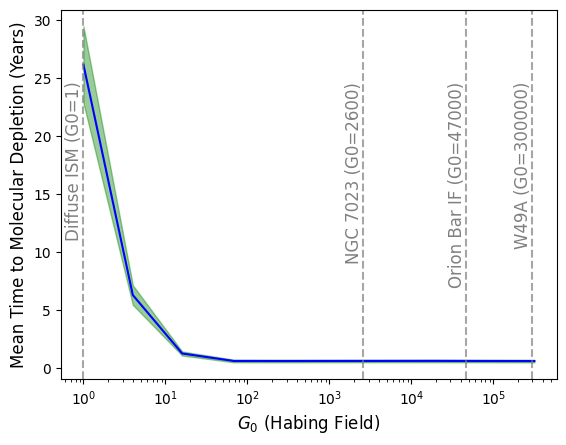

In [21]:
G0_values = np.logspace(0, 5.5, 10, dtype=int)  # 10 values from 1 to ~300,000
avg_years_to_zero_list = []
std_years_to_zero_list = []

for G0 in tqdm.tqdm(G0_values):
    n = 1000  
    num_molecules = 10000
    Nc = 17
    t_uv = 1.4e9 / (Nc * G0)
    dt = 3.1536e7 / 10

    all_years_to_zero = []

    for run in range(n):
        molecule_energies = np.full(num_molecules, E_min)
        molecule_alive = np.ones(num_molecules, dtype=bool)
        molecule_excited = np.zeros(num_molecules, dtype=bool)
        time_history = []
        current_time = 0.0

        while np.any(molecule_alive):
            alive_mask = molecule_alive
            E = molecule_energies[alive_mask]
            idx = np.where(alive_mask)[0]
            was_excited = molecule_excited[idx]

            k_RRKM = interp_RRKM(E)
            k_IR = interp_IR(E)
            k_RF = interp_RF(E)

            k_RRKM[E < other_C_RRKM_filtered_energies_list_eV[0]] = 0
            k_RF[E < RF_filtered_energies_list_eV[0]] = 0
            k_RRKM[~was_excited] = 0
            k_IR[~was_excited] = 0
            k_RF[~was_excited] = 0

            p_RRKM = k_RRKM * dt
            p_IR = k_IR * dt
            p_RF = k_RF * dt
            p_FUV_arr = np.full_like(p_RRKM, dt / t_uv)

            p_sum = p_RRKM + p_IR + p_RF + p_FUV_arr
            over_one = p_sum > 1
            p_RRKM[over_one] /= p_sum[over_one]
            p_IR[over_one]   /= p_sum[over_one]
            p_RF[over_one]   /= p_sum[over_one]
            p_FUV_arr[over_one] /= p_sum[over_one]

            rand = np.random.rand(np.sum(alive_mask))
            rrkm_mask = rand < p_RRKM
            ir_mask = (rand >= p_RRKM) & (rand < p_RRKM + p_IR)
            rf_mask = (rand >= p_RRKM + p_IR) & (rand < p_RRKM + p_IR + p_RF)
            fuv_mask = (rand >= p_RRKM + p_IR + p_RF) & (rand < p_RRKM + p_IR + p_RF + p_FUV_arr)

            molecule_alive[idx[rrkm_mask]] = False
            molecule_energies[idx[ir_mask]] = E_min
            molecule_excited[idx[ir_mask]] = False
            molecule_energies[idx[rf_mask]] = E_min
            molecule_excited[idx[rf_mask]] = False
            E_FUV_GAIN = np.random.uniform(0.5, 13.6, size=np.sum(fuv_mask))
            molecule_energies[idx[fuv_mask]] = np.minimum(E[fuv_mask] + E_FUV_GAIN, E_max)
            molecule_excited[idx[fuv_mask]] = True

            time_history.append(current_time)
            current_time += dt

        all_years_to_zero.append(time_history[-1] / 3.15576e7)

    avg_years_to_zero_list.append(np.mean(all_years_to_zero))
    std_years_to_zero_list.append(np.std(all_years_to_zero))

# REAL ASTROPHYSICAL REGIONS ANNOTATIONS
astro_G0s = [1, 2600, 47000, 300000]
astro_labels = [
    "Diffuse ISM (G0=1)",
    "NGC 7023 (G0=2600)",
    "Orion Bar IF (G0=47000)",
    "W49A (G0=300000)"
]

# PLOTTING
# plt.plot(G0_values, avg_years_to_zero_list, color='blue')
avg = np.array(avg_years_to_zero_list)
std = np.array(std_years_to_zero_list)
plt.plot(G0_values, avg, color='blue')
plt.fill_between(G0_values, avg-std, avg+std, color='green', alpha=0.4, label='Std. Dev.')
plt.xscale('log')
plt.xlabel(r'$G_0$ (Habing Field)', fontsize=12)
plt.ylabel('Mean Time to Molecular Depletion (Years)', fontsize=12)
for g0, label in zip(astro_G0s, astro_labels):
    plt.axvline(g0, color='gray', linestyle='--', alpha=0.7)
    plt.text(g0, plt.ylim()[1]*0.8, label, rotation=90, va='top', ha='right', fontsize=12, color='gray')
#plt.legend()
plt.show()